In [1]:
import pandas as pd
import numpy as np

from glob import glob
from configs import *
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

from sklearn.inspection import permutation_importance


paths = glob("results/predictions*")

df = []
for path in paths:
    tmp_df = pd.read_pickle(path)
    df.append(tmp_df)
df = pd.concat(df)


# Compute feature importance

In [2]:
def compute_feature_importances(target, df):
    
    df_feature_importances = []

    gb = df[df.target == target].groupby(["model", "config"])

    for idx, data in gb:

        if idx[0] == "LinearRegression":
            feature_importances = data.model_obj.iloc[0].coef_.tolist()

        elif idx[0] in ["MLPRegressor", "SVR", "KNeighborsRegressor"]:

            X_test = data.iloc[0].X_test.values
            y_test = data.iloc[0].y_test
            y_pred = data.iloc[0].y_pred
            model = data.iloc[0].model_obj

            if len(X_test)>0:
            
                r = permutation_importance(
                    model, X_test, y_test,
                    n_repeats=30,
                    random_state=0,
                )
            
                feature_importances = r.importances_mean
            
            else:
                # This is normal if you don't have access to the training data
                # and you are running the code on the 'results' folder shared
                # in the repository
                
                print(f"Warning: X_test is empty, feature importances will be None for all features | {idx[0]}")
                feature_importances = [None]*len(X_test)

        else:
            feature_importances = data.model_obj.iloc[0].feature_importances_.tolist()

        feature_names = data.X_train.iloc[0].columns.tolist()
        feature_importances = [(name, round(importance, 2)) for name, importance in zip(feature_names, feature_importances)]
        feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
        item = {x[0]: x[1] for x in feature_importances}
        item["model"] = idx[0]
        item["config"] = idx[1]

        df_feature_importances.append(item)

    df_feature_importances = pd.DataFrame(df_feature_importances)
    df_feature_importances = df_feature_importances[
        chm+\
        vegetation_indexes+\
        elevation_slope_aspect+\
        climatic+\
        ["model", "config"]
    ]
    
    return df_feature_importances

In [3]:
df_feature_importances_carbon = compute_feature_importances(TARGET_CARBON, df)
df_feature_importances_carbon_ic = compute_feature_importances(TARGET_CARBON_IC, df) 

# Plot feature importance

In [4]:
def plot_feature_importances(target, df_feature_importances, model):
    
    df_feature_importances.model = df_feature_importances.model.replace(name_mapping)
    data_to_plot = []

    for CONFIG in [CONFIG_0, CONFIG_3, CONFIG_2, CONFIG_1][::-1]:

        data_to_plot.append(df_feature_importances[
            (df_feature_importances.config == CONFIG.name) &\
            (df_feature_importances.model == model)
        ])


    i=0
    fig, axs = plt.subplots(
        figsize=(6, 10),
        nrows=len(data_to_plot),
        sharex=True,
        sharey=True,
    )

    ymax = 0

    for idx, data in enumerate(data_to_plot):

        ax = axs[idx]
        data = data.rename(columns=feature_mapping)
        data = data[feature_order+["model", "config"]]

        color = [color_mapping[x] for x in data.columns.tolist()[:-2]]

        f = data.iloc[i].values[:-2]

        ymax = max(ymax, np.nanmax(f))

        f = f.reshape(-1, 1)
        
        ax.bar(
            range(len(f)),
            f[:,0],
            width=1,
            alpha=1,
            label=data.iloc[i].model,
            color=color,
            ec="k",
            lw=.5,
            zorder=3,
        )

        ax.vlines(
            vlines_idxs,
            0, 1,
            colors="k",
            lw=.5,
            ls="-",
            transform=ax.get_xaxis_transform(),
            zorder=3,
        )

        ax.set_xticks(
            ticks=range(len(f)),
            labels=[x if ("max" in x and "spring" not in x) or (x == "PREC summer avg") else " ".join(x.split(" ")[1:]) for x in data.columns.tolist()[:-2]],
            rotation=90,
            ha="center",
        )
        ax.set_xlim(-1, len(f))

        ax.set_ylabel(config_mapping[data.iloc[i].config], fontweight="bold")
        

    ylims = ax.get_ylim()
    ylims = (ylims[0], ymax*1.1)
    ax.set_ylim(ylims)
    
    for idx, data in enumerate(data_to_plot):
        
        ax.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True)
        
        ax = axs[idx]

        if idx != len(data_to_plot)-1:
            ax.get_xaxis().set_visible(False)

        config_name = config_mapping[data.iloc[0].config]
        
        bar_args = dict(align="edge", ec="#0004", hatch=["////"], fc="#fff0", lw=0, zorder=3, height=ylims[1]+abs(ylims[0]), bottom=ylims[0])
        
        step = 0.04 if ylims[1] < 0.20 else 0.06
        
        ax.set_yticklabels([], rotation=30, va="bottom", ha="left")
        ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(step))
        ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter("{x:.2f}"))
        
        ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(step/2))
        
        ax.set_ylim(ylims)
        
        ax.grid(axis="y", zorder=0)
        ax.grid(axis="y", which="minor")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.0, hspace=0.05)

In [5]:
name_mapping = {
    'CatBoostRegressor':         "CatBoost",
    'GradientBoostingRegressor': "GBDT",
    'KNeighborsRegressor':       "KNN",
    'LinearRegression':          "MLR",
    'MLPRegressor':              "MLP",
    'RandomForestRegressor':     "RF",
    'SVR':                       "SVR",
    'XGBRegressor':              "XGBoost",
}

all_features = vegetation_indexes + chm + climatic + elevation_slope_aspect

color_mapping_helper = {
    "CHM": "cornflowerblue",
    
    "NDVI": "forestgreen",
    "NDII": "yellowgreen",
    "GNDVI": "y",
    "EVI": "limegreen",
    
    "ELE": "gray",
    "SLO": "tab:red",
    "ASP": "tab:pink",
    "PREC summer": "skyblue",
    "PREC spring": "skyblue",
    "TEMP summer": "orange",
    "TEMP spring": "orange",
}

cmap = mpl.cm.get_cmap('Set3')
for idx,k in enumerate(color_mapping_helper):
    color_mapping_helper[k] = cmap(idx/len(color_mapping_helper))

    
feature_mapping = {
    x: x.replace("pr_avg_JJA_median",  "PREC summer avg")\
        .replace("pr_avg_MAM_median",  "PREC spring avg")\
        .replace("tas_avg_JJA_median", "TEMP summer avg")\
        .replace("tas_max_JJA_median", "TEMP summer max")\
        .replace("tas_min_JJA_median", "TEMP summer min")\
        .replace("tas_avg_MAM_median", "TEMP spring avg")\
        .replace("tas_max_MAM_median", "TEMP spring max")\
        .replace("tas_min_MAM_median", "TEMP spring min")\
        .replace("_max", " max")\
        .replace("_min", " min")\
        .replace("_median", " med")\
        .replace("_mean", " avg")\
        .replace("_stdDev", " std")\
        .replace("_stdev", " std")\
        .replace("elevation", "ELE")\
        .replace("slope_percentage", "SLO")\
        .replace("aspect_degree", "ASP")\
        .replace("chm", "CHM")\
    for x in all_features
}

color_mapping = dict()
for x in feature_mapping.values():
    
    for k,v in list(color_mapping_helper.items())[::-1]:
        if k in x:
            color_mapping[x] = v
            break

feature_order = []

feature_order_helper = [
    
    "CHM",
    
    "NDVI",
    "NDII",
    "GNDVI",
    "EVI",
    
    "ELE",
    "SLO",
    "ASP",
    
    "TEMP sum",
    "TEMP spr",
    "PREC sum",
    "PREC spr",
]


for x in feature_order_helper:
    for adj in ["max", "min", "med", "avg", "std"]:
        
        for feature in feature_mapping.values():
            
            if x in feature and adj in feature:
                feature_order.append(feature)
                break

config_mapping = {
    "CONFIG_0": "Sentinel 2",
    "CONFIG_3": "Sentinel 2 + Climatic",
    "CONFIG_2": "Sentinel 2 + CHM",
    "CONFIG_1": "Sentinel 2 + Climatic + CHM",
}
tmp = [x.split(" ")[0] for x in feature_order]

chm_start = tmp.index("CHM")
chm_end = len(tmp) - tmp[::-1].index("CHM") -1

temp_start = tmp.index("TEMP")
temp_end = len(tmp) - tmp[::-1].index("TEMP") -1
prec_start = tmp.index("PREC")
prec_end = len(tmp) - tmp[::-1].index("PREC") -1
clim_start = min(temp_start, prec_start)
clim_end = max(temp_end, prec_end)

vlines_idxs = [chm_end+0.5, chm_start-0.5, clim_start-0.5, clim_end+0.5]
vlines_idxs.sort()
vlines_idxs = [x for x in vlines_idxs if x>0 and x<len(feature_order)-1]

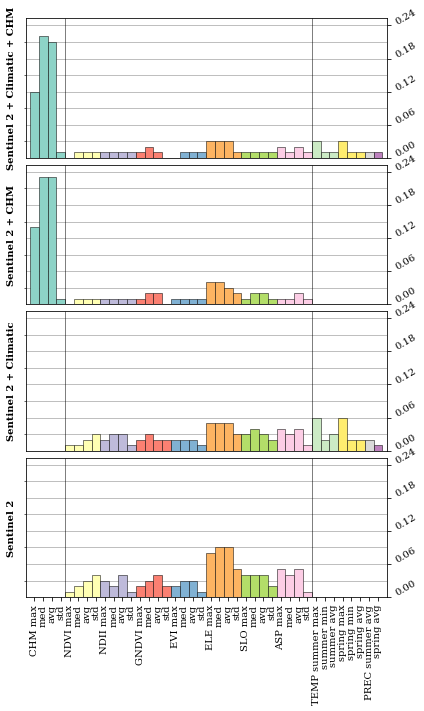

In [6]:
plot_feature_importances(TARGET_CARBON_IC, df_feature_importances_carbon, "RF")
plt.savefig("results/feature_importance_RF_CARBON.png", facecolor='white', bbox_inches='tight', dpi=100)
plt.savefig("results/feature_importance_RF_CARBON.pdf", bbox_inches='tight', dpi=200)
plt.show()

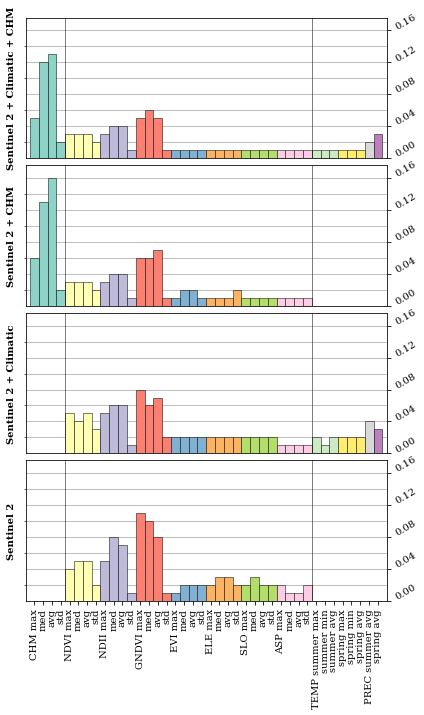

In [7]:
plot_feature_importances(TARGET_CARBON_IC, df_feature_importances_carbon_ic, "RF")
plt.savefig("results/feature_importance_RF_CARBON_IC.png", facecolor='white', bbox_inches='tight', dpi=100)
plt.savefig("results/feature_importance_RF_CARBON_IC.pdf", bbox_inches='tight', dpi=200)
plt.show()

In [8]:
import cv2

for img_name in ["CARBON", "CARBON_IC"]:

    image = cv2.imread(f"results/feature_importance_RF_{img_name}.png")
    image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite(f"results/feature_importance_RF_{img_name}_rot90.png", image)